# Code for 3d  coupled thermoelasticity of elastomersty of elastomers

Bending of a thermoelastic bilayer
The bottom layer expands on heating
The top layer does not expand on heating
        
Degrees of freedom: \
vectorial displacement: u \
pressure: p \
temperature: theta

Basic units: \
Length: mm \
Mass: kg \
Time: s \
Mass density: kg/mm^3 \
Force: milliN \
Stress: kPa  \
Energy: microJ \
Temperature: K \
Boltzmann Constant: 1.38E-17 microJ/K \
Number of polymer chains per unit vol: #/mm^3 \
Thermal expansion coefficient: #/K \
Specific heat: microJ/(mm^3 K) \
Thermal conductivity: microW/(mm K) 

Eric Stewart and Lallit Anand   
ericstew@mit.edu and anand@mit.edu   

Converted to FEniCSx by Jorge Nin
jorgenin@mit.edu
September 2023



In [1]:
import numpy as np
import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split)
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista
pyvista.set_jupyter_backend('client')
import matplotlib.pyplot as plt
## Define temporal parameters

### Set level of detail for log messages (integer)
Guide: \
CRITICAL  = 50  errors that may lead to data corruption \
ERROR     = 40  things that HAVE gone wrong \
WARNING   = 30  things that MAY go wrong later \
INFO      = 20  information of general interest (includes solver info) \
PROGRESS  = 16  what's happening (broadly) \
TRACE     = 13  what's happening (in detail) \
DBG       = 10  sundry 


In [2]:
log.set_log_level(log.LogLevel.WARNING)

# Define Geometry

In [3]:
name = "results/3D_thermoelas_solar_sail_plotting"
L0 = 100.0 # Radius
H0 = 1.0 #height
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0],[L0,L0,H0]],[10,10,2])

### Visualize Gemometry

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:62557/index.html?ui=P_0x10b748c50_0&reconnect=auto' style='width: …

## Functions for finding Differnent Areas

In [5]:
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], L0)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], L0)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], H0)

def pin1(x):
        return np.logical_and(np.isclose(x[0],0) , np.isclose(x[1], 0))

def pin2(x):
        return np.logical_and(np.isclose(x[0],L0) , np.isclose(x[1], L0))




In [6]:
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim-1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)

## Simulation Control

In [7]:
t    = 0.0   # initialization of time
Ttot = 100   # total simulation time 
dt   = 1     # Fixed step size

delta_theta = 50

press_max = 9.2e-3 # kPa

def pressRamp(t):
    return press_max*t/Ttot

## Function Spaces

$$ \frac{x}{y}$$


In [8]:
U2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2) # For displacement
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1) # For  pressure
TH = ufl.MixedElement([U2, P1,P1])     # Taylor-Hood style mixed element
ME = FunctionSpace(domain, TH)    # Total space for all DOFs

In [9]:
w = Function(ME)
u, p, theta= split(w)
w_old         = Function(ME)
u_old,  p_old, theta_old = split(w_old)

u_test, p_test, theta_test = TestFunctions(ME)       
dw = TrialFunction(ME)     

## SubRoutine

In [10]:
from subroutines import *
relations = ThermoElastic3D(u,p,theta,u_old,p_old,theta_old,domain)

In [11]:
#Initialize Temperatures
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))

## WEAK FORMS

In [12]:
dxs = dx(metadata={'quadrature_degree': 4})

In [13]:
Tmat,J =relations.Kinematics()

dk = Constant(domain,PETSc.ScalarType(dt))
pressure = Constant(domain,PETSc.ScalarType(pressRamp(t)))
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)
# Res_2: Balance of energy  (test fxn: thetau)
Fcof = J*inv(relations.F.T)
traction = - pressure*dot(Fcof,n)
# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , grad(u_test))*dxs - dot(traction, u_test)*ds(6) 


# The weak form for the pressure
fac_p =  ( ln(J) - 3*relations.alpha*(theta-relations.theta0) )/J
#
Res_1 = dot( (p/relations.Kbulk + fac_p), p_test)*dxs

# The weak form for heat equation
Res_2 = dot(relations.c_v*(theta - theta_old), theta_test)*dxs \
        -  (1/2)*theta * inner(relations.M, (relations.C - relations.C_old)) * theta_test*dxs \
        -  dk*dot(relations.Qmat , grad(theta_test) )*dxs

# Total weak form
Res = Res_0 +  Res_1 + Res_2 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [14]:
def thetaRamp(t):
    return relations.theta0.value+delta_theta*t/Ttot

TempRamp = Constant(domain,PETSc.ScalarType(thetaRamp(t)))
Zero = Constant(domain,PETSc.ScalarType(0))
V0, submap = ME.sub(0).collapse()
fixed_displacement = fem.Function(V0)
fixed_displacement.interpolate(lambda x: np.stack((np.zeros(x.shape[1]), np.zeros(x.shape[1]),np.zeros(x.shape[1]))))


#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))

dofs_1 = fem.locate_dofs_geometrical((ME.sub(0),V0), pin1)
dofs_2 = fem.locate_dofs_geometrical((ME.sub(0),V0), pin2)

dofs_3 = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
dofs_4 = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(3))
dofs_5 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(5))
dofs_6 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(6))


bcs_1 = dirichletbc(fixed_displacement, dofs_1,ME.sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(fixed_displacement, dofs_2, ME.sub(0))  # u2 fix - yBot
bcs_3 = dirichletbc(0.0,dofs_3 ,ME.sub(0).sub(0))  # u3 fix - zBot
bcs_4 = dirichletbc(0.0,dofs_4 ,ME.sub(0).sub(1))  # u3 fix - zBot

bcs_5 = dirichletbc(TempRamp,dofs_5 ,ME.sub(2))  # u3 fix - zBot
bcs_6 = dirichletbc(TempRamp,dofs_5 ,ME.sub(2))  # u3 fix - zBot

#
bcs = [bcs_1, bcs_2, bcs_3,bcs_4,bcs_5,bcs_6]

## Non Linear Variational

In [15]:
## Functions for visualization


U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, P1)#Scalar function space

u_r = Function(V2)
u_r.name = "disp"

p_r = Function(V1)
p_r.name = "p"

theta_r = Function(V1)
theta_r.name="theta"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())


lambdaBar_Vis = Function(V1)
lambdaBar_Vis.name = "lambdaBar"
lambdaBar_expr = Expression(relations.lambdaBar,V1.element.interpolation_points())

 # Visualize M:Cdot
MCdotExpr = Expression(inner(relations.M, (relations.C-relations.C_old)/dt),V1.element.interpolation_points())

MCdot_Vis = Function(V1)
MCdot_Vis.name = "M:Cdot"

delta_theta_vis = Function(V1)
delta_theta_Exp=Expression(theta -relations.theta0,V1.element.interpolation_points())
delta_theta_vis.name = "Delta Theta"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*relations.F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_Vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

def InterpAndSave(t,file):
    u_r.interpolate(w.sub(0))
    p_r.interpolate(w.sub(1))
    theta_r.interpolate(w.sub(2))
    delta_theta_vis.interpolate(delta_theta_Exp)
    J_vis.interpolate(J_expr)
    P11.interpolate(P11_expr)
    P22.interpolate(P22_expr)
    P33.interpolate(P33_expr)
    lambdaBar_Vis.interpolate(lambdaBar_expr)
    Mises_Vis.interpolate(Mises_expr)
    MCdot_Vis.interpolate(MCdotExpr)

    if file is not None:
        file.write_function(u_r,t)
        file.write_function(p_r,t)
        file.write_function(theta_r,t)
        file.write_function(delta_theta_vis,t)
        file.write_function(J_vis,t)
        file.write_function(P11,t)
        file.write_function(P22,t)
        file.write_function(P33,t)
        file.write_function(lambdaBar_Vis,t)
        file.write_function(Mises_Vis,t)
        file.write_function(MCdot_Vis,t)


pointForStress = [L0,0,0]
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForStress)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForStress)
 

engineeringStress= fem.form(2*np.pi*relations.x[0]*P22*ds(4)) #P22/area*ds

------------------------------------
Simulation Start
------------------------------------
Step: Press/temp loading | Simulation Time: 1 s, Wallclock Time: 01:08:51
Iterations: 7

Step: Press/temp loading | Simulation Time: 2 s, Wallclock Time: 01:08:53
Iterations: 5

Step: Press/temp loading | Simulation Time: 3 s, Wallclock Time: 01:08:54
Iterations: 5

Step: Press/temp loading | Simulation Time: 4 s, Wallclock Time: 01:08:56
Iterations: 5

Step: Press/temp loading | Simulation Time: 5 s, Wallclock Time: 01:08:57
Iterations: 5

Step: Press/temp loading | Simulation Time: 6 s, Wallclock Time: 01:08:58
Iterations: 4

Step: Press/temp loading | Simulation Time: 7 s, Wallclock Time: 01:08:59
Iterations: 4

Step: Press/temp loading | Simulation Time: 8 s, Wallclock Time: 01:09:00
Iterations: 4

Step: Press/temp loading | Simulation Time: 9 s, Wallclock Time: 01:09:01
Iterations: 4

Step: Press/temp loading | Simulation Time: 10 s, Wallclock Time: 01:09:02
Iterations: 4

Step: Press/temp l

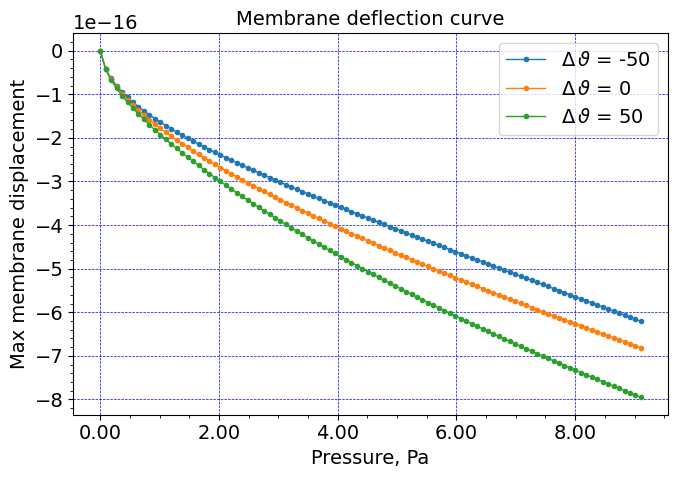

In [16]:

startTime = datetime.now()
step = "Press/temp loading"
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}



problem = NonlinearProblem(Res, w, bcs, a)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize time history variables.
siz  = 100000 
temp_out = np.zeros(siz)
disp_out = np.zeros(siz)
time_out = np.zeros(siz)
temp_out[0] = relations.theta0# initial temp
    
import os
for delta_theta in [-50, 0, 50]:

    #if os.path.exists(name+".xdmf"):
    #    os.remove(name+".xdmf")
    #    os.remove(name+".h5")
    ##xdmf = XDMFFile(domain.comm, name+".xdmf", "w")
    #xdmf.write_mesh(domain)

    #reinitialize
    w.sub(0).x.array[:] = 0
    w.sub(1).x.array[:] = 0
    w_old.sub(0).x.array[:] = 0
    w_old.sub(1).x.array[:] = 0
    w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))
    w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))

    InterpAndSave(t,None)


    print("------------------------------------")
    print("Simulation Start")
    print("------------------------------------")
    # Store start time 
    startTime = datetime.now()
    #log.set_log_level(log.LogLevel.INFO)
    t = 0
    ii = 0
    while (t < Ttot):
        
        # increment time
        t += dt 
        # increment counter
        ii += 1
        
        # update time variables in time-dependent BCs 
        TempRamp.value = thetaRamp(t)
        pressure.value = pressRamp(t)
        
        # Solve the problem
        try:
            (iter, converged) = solver.solve(w)
        except: # Break the loop if solver fails
            print( "Ended Early")
            break

        w.x.scatter_forward()
        # Write output to *.xdmf file
        #writeResults(t)
        #print(u0.x.array-w.x.array[dofs])


        # Update DOFs for next step
        w_old.x.array[:] = w.x.array


        #SAVING RESULT
        InterpAndSave(t,None)

        # Store  displacement at a particular point  at this time
        disp_out[ii] =  w.sub(0).sub(2).eval(pointForStress,colliding_cells[0])[0]
        temp_out[ii] = w.sub(2).eval(pointForStress,colliding_cells[0])[0]
        time_out[ii] = t # current time
        # Print progress of calculation
        if ii%1 == 0:      
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
                format(step, round(t,4), current_time))
            print("Iterations: {}".format(iter))
            print()  
            


    plotter.close()
    print("-----------------------------------------")
    print("End computation")                 
    # Report elapsed real time for the analysis
    endTime = datetime.now()
    elapseTime = endTime - startTime
    print("------------------------------------------")
    print("Elapsed real time:  {}".format(elapseTime))
    print("------------------------------------------")
    

    # Set up font size, initialize colors array
    font = {'size'   : 14}
    plt.rc('font', **font)
    #
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors     = prop_cycle.by_key()['color']
    
    # Only plot as far as we have time history data
    ind = np.argmax(time_out)
    
    # Create figure for temperature-displacement curve.
    #
    # fig = plt.figure() 
    plt.plot( press_max*time_out[0:ind]/Ttot*1000, disp_out[0:ind], linewidth=1.0, marker='.',\
             label=r"$\Delta\,\vartheta$ = {:1.0f}".format(delta_theta) )
    #-------------------------------------------------------------------------------
    plt.grid(linestyle="--", linewidth=0.5, color='b')
    fig = plt.gcf()
    ax = fig.gca()  
    ax.set_xlabel("Pressure, Pa",size=14)
    ax.set_ylabel("Max membrane displacement",size=14)
    ax.set_title("Membrane deflection curve", size=14, weight='normal')
    #
    from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    #plt.legend()
    import matplotlib.ticker as ticker
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Set up font size, initialize colors array
plt.legend()
# plt.show()
# Save figure to file
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_solar_sail_plotting.png", dpi=600) 